In [1]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import sklearn.metrics as sm
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import scipy.misc as sc
     

In [2]:
import numpy as np
import cv2
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from keras.preprocessing.image import ImageDataGenerator
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATASET = 'MENDELEY'

if DATASET == 'MENDELEY':
    PATH = '/content/drive/MyDrive/AV_split/'
    TRAIN_PATH = PATH+'train/'
    TRAIN_IMAGE_PATH = TRAIN_PATH + 'images'
    TRAIN_MASK_PATH = TRAIN_PATH + 'GT_vessel'
    TRAIN_TARGET_SIZE = (512,512)
    
    TEST_PATH = PATH+'test/'
    TEST_IMAGE_PATH = TEST_PATH + 'images'
    TEST_MASK_PATH = TEST_PATH + 'GT_vessel'
    TEST_TARGET_SIZE = (512,512)
    SAVE_TEST_IMAGE_PATH = TEST_PATH + 'predict'
    
elif DATASET == 'STARE':
    PATH = '/content/drive/MyDrive/STARE/'
    TRAIN_PATH = PATH+'train/'
    TRAIN_IMAGE_PATH = TRAIN_PATH + 'images'
    TRAIN_MASK_PATH = TRAIN_PATH + 'GT'
    TRAIN_TARGET_SIZE = (512,512)
    
    TEST_PATH = PATH+'test/'
    TEST_IMAGE_PATH = TEST_PATH + 'images'
    TEST_MASK_PATH = TEST_PATH + 'GT'
    TEST_TARGET_SIZE = (512,512)
    SAVE_TEST_IMAGE_PATH = TEST_PATH + 'predict'

0.00784313725490196 0.8666666666666667
(512, 512, 1)
[0.00784314 0.01176471 0.01568627 0.01960784 0.02352941 0.02745098
 0.03137255 0.03529412 0.03921569 0.04313725 0.04705882 0.05098039
 0.05490196 0.05882353 0.0627451  0.06666667 0.07058824 0.0745098
 0.07843137 0.08235294 0.08627451 0.09019608 0.09411765 0.09803922
 0.10196078 0.10588235 0.10980392 0.11372549 0.11764706 0.12156863
 0.1254902  0.12941176 0.13333333 0.1372549  0.14117647 0.14509804
 0.14901961 0.15294118 0.15686275 0.16078431 0.16470588 0.16862745
 0.17254902 0.17647059 0.18039216 0.18431373 0.18823529 0.19215686
 0.19607843 0.2        0.20392157 0.20784314 0.21176471 0.21568627
 0.21960784 0.22352941 0.22745098 0.23137255 0.23529412 0.23921569
 0.24313725 0.24705882 0.25098039 0.25490196 0.25882353 0.2627451
 0.26666667 0.27058824 0.2745098  0.27843137 0.28235294 0.28627451
 0.29019608 0.29411765 0.29803922 0.30196078 0.30588235 0.30980392
 0.31372549 0.31764706 0.32156863 0.3254902  0.32941176 0.33333333
 0.3372549 

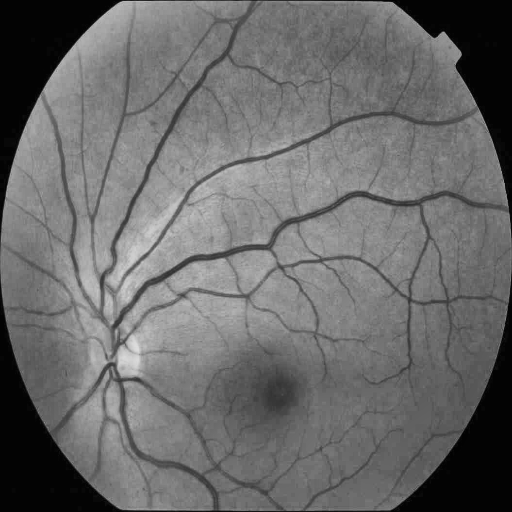

In [5]:
from google.colab.patches import cv2_imshow
def clahe_equalized(image):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    image_equalized = clahe.apply(image)
    
    return image_equalized

def image_aug(image):
    image = image[:,:,1]
    image = clahe_equalized(image)

    # av_split img shaoe 1000, 1504
    if DATASET == 'MENDELEY':
      image = image[70:970, 200:1255]

    image = cv2.resize(image, (512, 512))
    image = np.reshape(image, image.shape + (1,))

    image = image / 255
    return image

if DATASET == 'MENDELEY':
  image = cv2.imread(
    '/content/drive/MyDrive/AV_split/train/images/IM000001.JPG', 
  )
elif DATASET == 'STARE':
  image = cv2.imread(
    '/content/drive/MyDrive/STARE/train/images/im0001.ppm', 
  )

image = image_aug(image)

print(image.min(), image.max())
print(image.shape)
print(np.unique(image))
cv2_imshow(image*255)

0.0 1.0
(512, 512, 1)
[0. 1.]


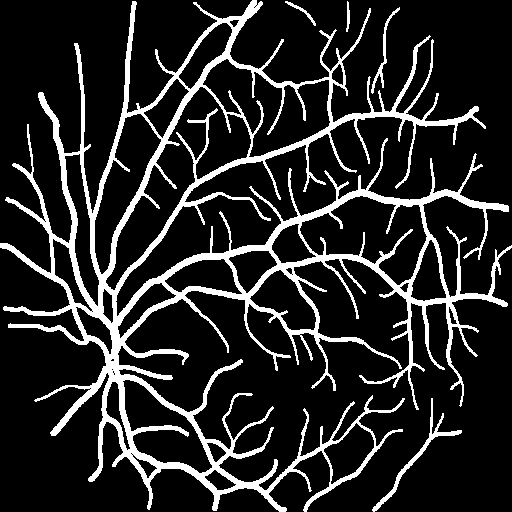

In [6]:
from google.colab.patches import cv2_imshow

def mask_aug(mask):
    thresh = 128
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]

    mask = mask[70:970, 200:1255]
    mask = cv2.resize(mask, (512, 512))
    mask = np.reshape(mask, mask.shape + (1,))

    if DATASET == 'MENDELEY':
        mask = 255 - mask
    
    mask = mask / 255

    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return mask

if DATASET == 'MENDELEY':
    mask = cv2.imread(
        '/content/drive/MyDrive/AV_split/train/GT_vessel/IM000001--vessels.jpg', 
        cv2.IMREAD_GRAYSCALE)
elif DATASET == 'STARE':
    mask = cv2.imread(
        '/content/drive/MyDrive/STARE/train/GT/im0001.ah.ppm', 
        cv2.IMREAD_GRAYSCALE)
mask = mask_aug(mask)

print(mask.min(), mask.max())
print(mask.shape)
print(np.unique(mask))

cv2_imshow(mask*255)

In [7]:
from random import shuffle

def get_img_mask_path(image_folder, path_folder):
    images = sorted(os.listdir(image_folder)) 
    masks = sorted(os.listdir(path_folder))  

    images_masks_path = []
    for image_path, mask_path in zip(images, masks):
        images_masks_path.append((
            image_folder + '/' + image_path, 
            path_folder + '/' + mask_path))

    return images_masks_path

def train_generator(img_label_list, batch_size, input_size):
    shuffle(img_label_list) 
    ids_train_split = range(len(img_label_list))
    while True:
         for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]
            for id in ids_train_batch:
                img = cv2.imread(img_label_list[id][0])
                img = image_aug(img)

                mask = cv2.imread(img_label_list[id][1], cv2.IMREAD_GRAYSCALE)
                mask = mask_aug(mask)

                x_batch.append(img)
                y_batch.append(mask)

            x_batch = np.array(x_batch, np.float32) 
            y_batch = np.array(y_batch, np.float32)

            yield x_batch, y_batch

In [8]:
train_images_masks_path = get_img_mask_path(TRAIN_IMAGE_PATH, TRAIN_MASK_PATH)
train_gen = train_generator(
    train_images_masks_path,
    5,
    TRAIN_TARGET_SIZE
)

val_images_masks_path = get_img_mask_path(TEST_IMAGE_PATH, TEST_MASK_PATH)
val_gen = train_generator(
    val_images_masks_path,
    5,
    TEST_TARGET_SIZE
)

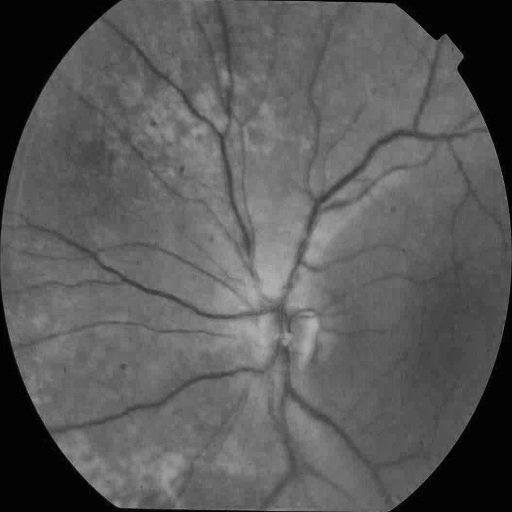

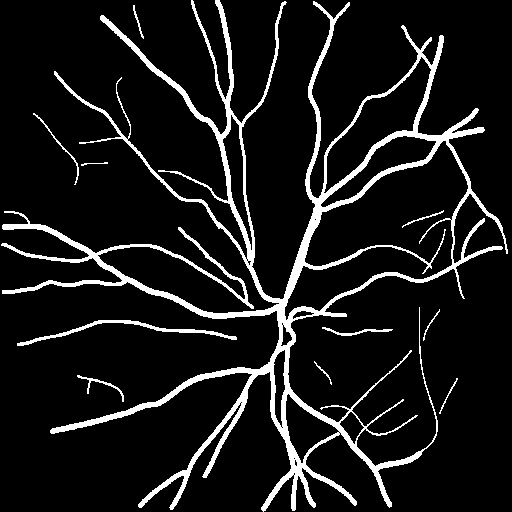

In [9]:
from google.colab.patches import cv2_imshow
from PIL import Image

x, y = next(train_gen)
for i in range(0,1):
    image = x[i]
    mask = y[i]
    cv2_imshow(image * 255)
    cv2_imshow(mask * 255)

In [10]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5, training=True)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [11]:
model = unet()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_STARE.hdf5', monitor='loss', verbose=1, save_best_only=True)
callbacks = [ model_checkpoint ]

history = model.fit(
    train_gen,
    steps_per_epoch=10,
    epochs=80,
    verbose=0,
    callbacks=callbacks)


Epoch 1: loss improved from inf to 4.56868, saving model to unet_STARE.hdf5

Epoch 2: loss improved from 4.56868 to 0.24447, saving model to unet_STARE.hdf5

Epoch 3: loss improved from 0.24447 to 0.23393, saving model to unet_STARE.hdf5

Epoch 4: loss improved from 0.23393 to 0.21326, saving model to unet_STARE.hdf5

Epoch 5: loss improved from 0.21326 to 0.20767, saving model to unet_STARE.hdf5

Epoch 6: loss improved from 0.20767 to 0.20443, saving model to unet_STARE.hdf5

Epoch 7: loss improved from 0.20443 to 0.20179, saving model to unet_STARE.hdf5

Epoch 8: loss improved from 0.20179 to 0.19967, saving model to unet_STARE.hdf5

Epoch 9: loss improved from 0.19967 to 0.19765, saving model to unet_STARE.hdf5

Epoch 10: loss improved from 0.19765 to 0.19540, saving model to unet_STARE.hdf5

Epoch 11: loss improved from 0.19540 to 0.19416, saving model to unet_STARE.hdf5

Epoch 12: loss improved from 0.19416 to 0.19143, saving model to unet_STARE.hdf5

Epoch 13: loss did not impro

In [12]:
acc = history.history['accuracy']
loss = history.history['loss']

max_acc = max(acc)
max_acc_i = acc.index(max_acc)
loss_at_max_acc = loss[max_acc_i]

print('acc:', max_acc, 'loss:', loss_at_max_acc)

acc: 0.9831444025039673 loss: 0.07691328227519989


In [52]:
def test_generator(test_image_path):
    files = sorted(os.listdir(test_image_path))
    for e in files:
        path = test_image_path + '/' + e
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        if DATASET == 'MENDELEY':
            img = img[70:970, 200:1255]

        img = cv2.resize(img, (512, 512))
        img = np.reshape(img,img.shape+(1,))
        img = np.reshape(img,(1,)+img.shape)

        yield img

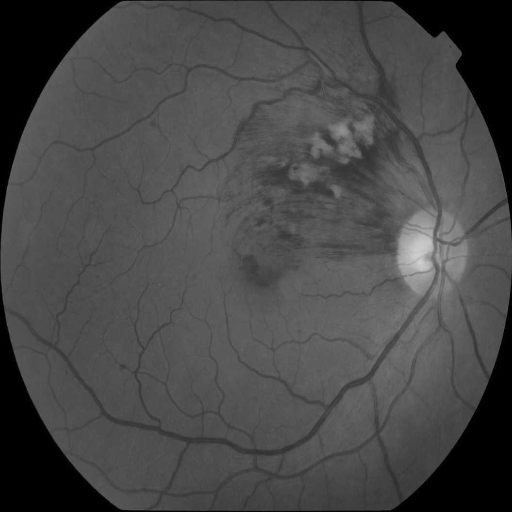

In [55]:
test_gen = test_generator(TEST_IMAGE_PATH)
x = next(test_gen)
for i in range(0,1):
    image = x[i]
    cv2_imshow(image)

In [56]:
def save_result(npyfile):
    files = os.listdir(TEST_IMAGE_PATH)
    
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        img[img > 0.1] = 1
        img[img <= 0.1] = 0

        io.imsave(os.path.join(SAVE_TEST_IMAGE_PATH, files[i]+'_predict.png'),img)

if not os.path.exists(SAVE_TEST_IMAGE_PATH):
    os.makedirs(SAVE_TEST_IMAGE_PATH)

In [57]:
n_i = len(os.listdir(TEST_IMAGE_PATH))
results = model.predict_generator(test_gen,n_i,verbose=1)
save_result(results)

1/5 [=====>........................] - ETA: 0s

<ipython-input-57-9045d621c6ff>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = model.predict_generator(test_gen,n_i,verbose=1)


4/5 [=======================>......] - ETA: 0s

5/5 [==============================] - 1s 131ms/step


<ipython-input-56-a01732a485f1>:9: UserWarning: /content/drive/MyDrive/AV_split/test/predict/IM006106.JPG_predict.png is a low contrast image
  io.imsave(os.path.join(SAVE_TEST_IMAGE_PATH, files[i]+'_predict.png'),img)
<ipython-input-56-a01732a485f1>:9: UserWarning: /content/drive/MyDrive/AV_split/test/predict/IM006105.JPG_predict.png is a low contrast image
  io.imsave(os.path.join(SAVE_TEST_IMAGE_PATH, files[i]+'_predict.png'),img)
<ipython-input-56-a01732a485f1>:9: UserWarning: /content/drive/MyDrive/AV_split/test/predict/IM006037.JPG_predict.png is a low contrast image
  io.imsave(os.path.join(SAVE_TEST_IMAGE_PATH, files[i]+'_predict.png'),img)
<ipython-input-56-a01732a485f1>:9: UserWarning: /content/drive/MyDrive/AV_split/test/predict/IM005834.JPG_predict.png is a low contrast image
  io.imsave(os.path.join(SAVE_TEST_IMAGE_PATH, files[i]+'_predict.png'),img)
